In [23]:
import os

folder = "models"
mode_version = "spec_trialv0"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models\spec_trialv0


In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

#from kerastuner import HyperModel

<h2>Data Loading and Preparation</h2>

In [4]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [5]:
image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [6]:
X_all = []
Y_all = []

image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [7]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [8]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2> Train and Save Model</h2>

In [9]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [10]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 56)        224       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 56)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 22, 72)        100872

In [24]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.2,
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1



    
    
    

Train on 1931 samples, validate on 483 samples
Epoch 1/5
1931/1931 - 13s - loss: 1.0226 - accuracy: 0.6908 - val_loss: 6.8486 - val_accuracy: 0.0476
Epoch 2/5
1931/1931 - 10s - loss: 0.8285 - accuracy: 0.7514 - val_loss: 8.7462 - val_accuracy: 0.0476
Epoch 3/5
1931/1931 - 9s - loss: 0.7526 - accuracy: 0.7519 - val_loss: 14.6120 - val_accuracy: 0.0476
Epoch 4/5
1931/1931 - 9s - loss: 0.6344 - accuracy: 0.7887 - val_loss: 11.7363 - val_accuracy: 0.0683
Epoch 5/5
1931/1931 - 10s - loss: 0.5428 - accuracy: 0.8131 - val_loss: 11.1012 - val_accuracy: 0.0497
models\spec_trialv0_iter_1.model
INFO:tensorflow:Assets written to: models\spec_trialv0_iter_1.model\assets
Train on 1931 samples, validate on 483 samples
Epoch 1/5
1931/1931 - 11s - loss: 1.0208 - accuracy: 0.6867 - val_loss: 6.5054 - val_accuracy: 0.0393
Epoch 2/5
1931/1931 - 9s - loss: 0.8273 - accuracy: 0.7494 - val_loss: 7.6287 - val_accuracy: 0.0600
Epoch 3/5
1931/1931 - 9s - loss: 0.7135 - accuracy: 0.7778 - val_loss: 7.8242 - val_

# Load and Evaluate

In [28]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=8


In [29]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

C:\Users\Tasli\Anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tasli\Anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


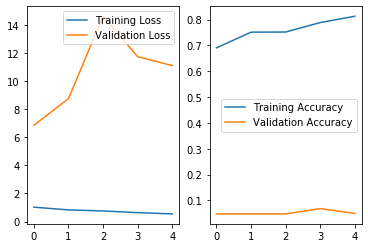

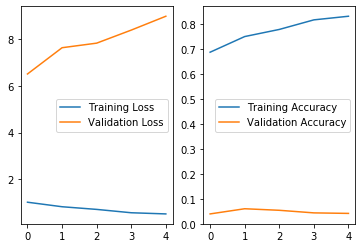

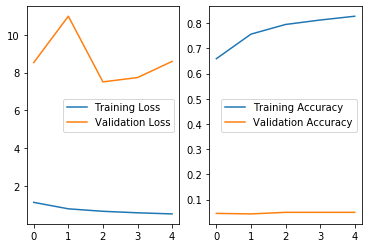

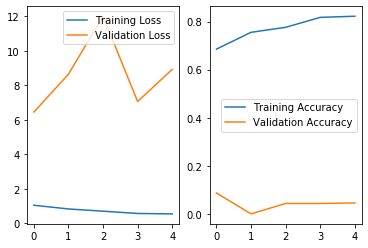

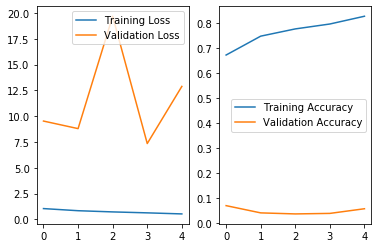

In [30]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [31]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.         0.         0.         0.         0.         0.
 0.04009313 0.        ]
precision sdev by class [0.        0.        0.        0.        0.        0.        0.0006836
 0.       ]
macro precision mean 0.005011641571392485
macro precision sdev 8.544939928351997e-05
recall mean [0. 0. 0. 0. 0. 0. 1. 0.]
recall sdev [0. 0. 0. 0. 0. 0. 0. 0.]
macro recall mean 0.125
macro recall sdev 0.0
f1 mean [0.         0.         0.         0.         0.         0.
 0.07709444 0.        ]
f1 sdev [0.         0.         0.         0.         0.         0.
 0.00126258 0.        ]
macro f1 mean 0.009636805534391857
macro f1 sdev 0.00015782226315594775
accuracy mean 0.04009313257113988
accuracy sdev 0.0006835951942681598


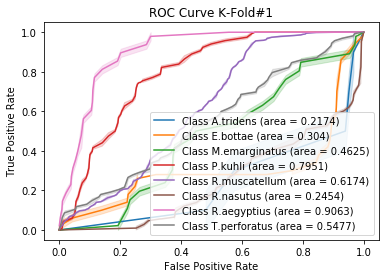

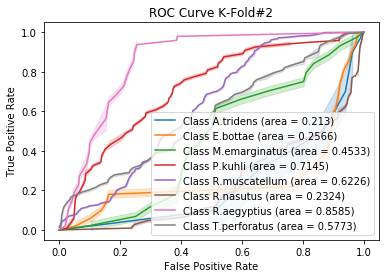

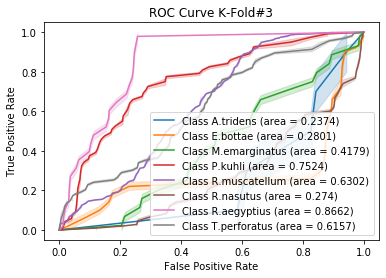

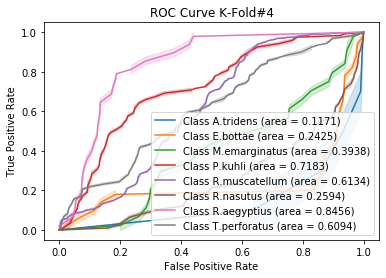

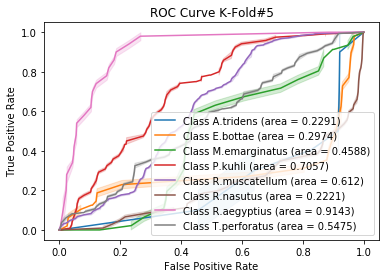

In [34]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [42]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  0.20278669577500966
Std  0.04371914932458824
Sp:  E.bottae
AUC Mean  0.27614192030566165
Std  0.023494504389128392
Sp:  M.emarginatus
AUC Mean  0.4372570833969653
Std  0.026929286673850326
Sp:  P.kuhli
AUC Mean  0.7372030867745952
Std  0.032988103496441816
Sp:  R.muscatellum
AUC Mean  0.6191096016065266
Std  0.0066526175662985874
Sp:  R.nasutus
AUC Mean  0.2466679411683364
Std  0.018528885794159344
Sp:  R.aegyptius
AUC Mean  0.8781997302029969
Std  0.027166501878224506
Sp:  T.perforatus
AUC Mean  0.5795106578854188
Std  0.029148911294369317


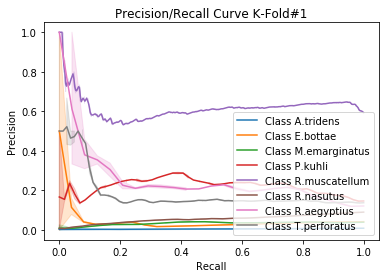

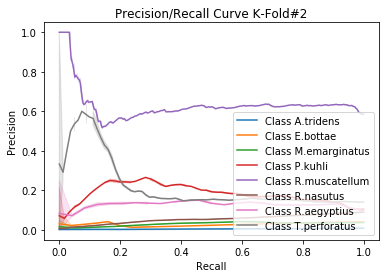

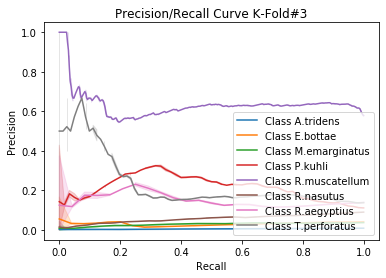

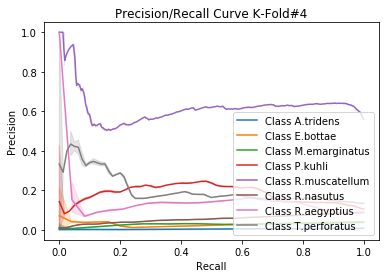

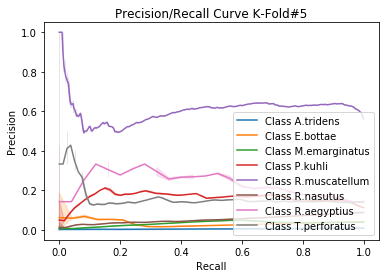

In [35]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0  25   0]
 [  0   0   0   0   0   0  23   0]
 [  0   0   0   0   0   0  59   0]
 [  0   0   0   0   0   0 333   0]
 [  0   0   0   0   0   0  54   0]
 [  0   0   0   0   0   0  24   0]
 [  0   0   0   0   0   0  81   0]]


Confusion Matrix K-Fold #2

[[  0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0  25   0]
 [  0   0   0   0   0   0  22   0]
 [  0   0   0   0   0   0  60   0]
 [  0   0   0   0   0   0 333   0]
 [  0   0   0   0   0   0  54   0]
 [  0   0   0   0   0   0  24   0]
 [  0   0   0   0   0   0  81   0]]


Confusion Matrix K-Fold #3

[[  0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0  25   0]
 [  0   0   0   0   0   0  22   0]
 [  0   0   0   0   0   0  60   0]
 [  0   0   0   0   0   0 333   0]
 [  0   0   0   0   0   0  54   0]
 [  0   0   0   0   0   0  24   0]
 [  0   0   0   0   0   0  81   0]]


Confusion Matrix K-Fold #4

[[  0   0   0   0   0   0   5   0]
 [  

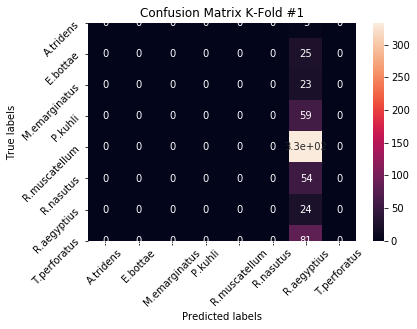

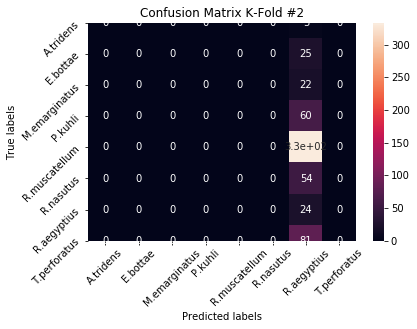

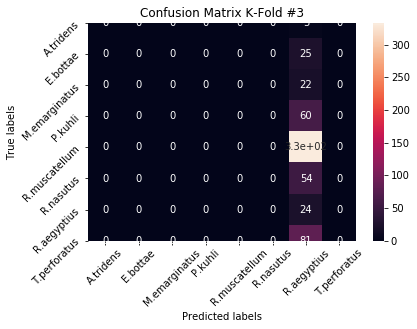

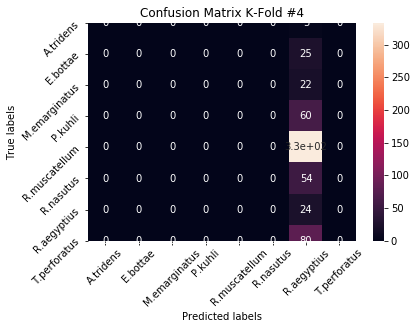

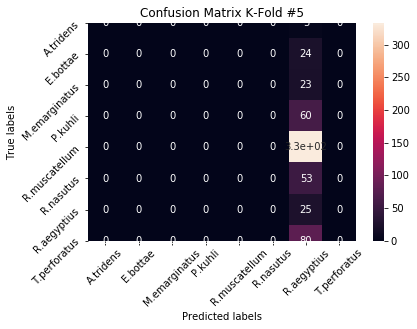

In [36]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[   0    0    0    0    0    0   25    0]
 [   0    0    0    0    0    0  124    0]
 [   0    0    0    0    0    0  112    0]
 [   0    0    0    0    0    0  299    0]
 [   0    0    0    0    0    0 1665    0]
 [   0    0    0    0    0    0  269    0]
 [   0    0    0    0    0    0  121    0]
 [   0    0    0    0    0    0  403    0]]

average of all confuion matrices
 [[  0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0  24   0]
 [  0   0   0   0   0   0  22   0]
 [  0   0   0   0   0   0  59   0]
 [  0   0   0   0   0   0 333   0]
 [  0   0   0   0   0   0  53   0]
 [  0   0   0   0   0   0  24   0]
 [  0   0   0   0   0   0  80   0]]


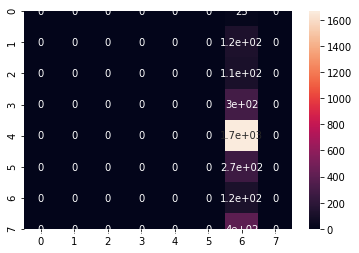

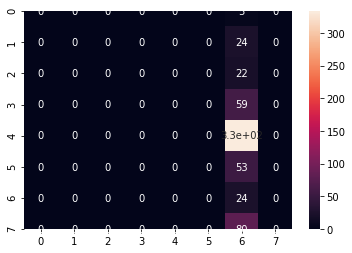

In [37]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


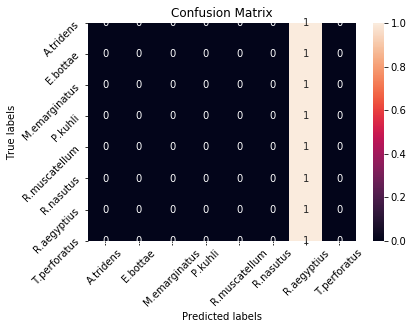

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);